In [18]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [ ]:
'Year','CRSDepTime','ArrTime','CRSArrTime','CRSElapsedTime'

In [2]:
def load_data():
    cols_91 = ['Month','DayofMonth','DayOfWeek','DepTime','UniqueCarrier','FlightNum','ActualElapsedTime','ArrDelay','DepDelay','Origin','Dest','Distance','Cancelled','Diverted']
    cols_01 = ['Month','DayofMonth','DayOfWeek','DepTime','UniqueCarrier','FlightNum','TailNum','ActualElapsedTime','AirTime','ArrDelay','DepDelay','Origin','Dest','Distance','TaxiIn','TaxiOut','Cancelled','Diverted']
    return pd.read_csv("1991_cleaned.csv.gz", encoding='cp1252', compression="gzip", usecols=cols_91), pd.read_csv("2001_cleaned.csv.gz", encoding='cp1252', compression="gzip", usecols=cols_01)

In [3]:
df91, df01 = load_data()

In [ ]:
df91.sample(10)

In [4]:
df01 = df01.sample(10000)
df91 = df91.sample(10000)

In [5]:
def process_and_save_data(df, categorical_cols, numerical_cols, filename):
    # Handling missing values
    df = df.dropna()  # Dropping rows with missing values or use df.fillna() to impute missing values

    # Apply conditions using np.where with .loc
    df['OnTime'] = (df['ArrDelay'] <= 0).astype(int)

    # Separate features and the modified target variable
    X = df.drop(columns=['ArrDelay', 'OnTime'])  # Features
    y = df['OnTime']  # Target variable

    # Handle missing values in the numerical columns (if any)
    imputer = SimpleImputer(strategy='mean')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

    # Scale numerical columns
    scaler = StandardScaler()
    X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

    # Apply Label Encoding to categorical columns
    encoder = LabelEncoder()
    X_encoded = X[categorical_cols].apply(encoder.fit_transform)

    # Combine encoded and non-categorical columns
    X_processed = pd.concat([X_encoded.reset_index(drop=True), X[numerical_cols].reset_index(drop=True)], axis=1)

    # Combine X_processed and y into a single DataFrame
    combined_df = pd.concat([X_processed, y], axis=1)

    # Save the combined DataFrame to a CSV file
    combined_df.sample(100).to_csv(filename, index=False)
    
    return combined_df

In [6]:
processed_df91 =  process_and_save_data(df91, ['UniqueCarrier', 'Origin', 'Dest'],['Month','DayofMonth','DayOfWeek','DepTime','FlightNum','ActualElapsedTime','DepDelay','Distance','Cancelled','Diverted'], 'pdf91.csv')

In [7]:
processed_df01 = process_and_save_data(df01, ['UniqueCarrier','TailNum' ,'Origin', 'Dest'],['Month','DayofMonth','DayOfWeek','DepTime','FlightNum','ActualElapsedTime','DepDelay','Distance','TaxiIn','TaxiOut','Cancelled','Diverted'], 'pdf01.csv')

In [8]:
processed_df91 = processed_df91.dropna()

In [9]:
processed_df01 = processed_df01.dropna()

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

def train_decision_tree_classifier(processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features
    y = processed_df['OnTime']  # Target variable

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the Decision Tree Classifier
    dt_classifier = DecisionTreeClassifier(random_state=42)
    dt_classifier.fit(X_train, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = dt_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return dt_classifier, accuracy

In [11]:
from sklearn.linear_model import LogisticRegression

def train_logistic_regression(processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features
    y = processed_df['OnTime']  # Target variable

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the Logistic Regression Classifier
    log_reg = LogisticRegression(random_state=42)
    log_reg.fit(X_train, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = log_reg.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return log_reg, accuracy

In [12]:
def train_decision_tree(processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features
    y = processed_df['OnTime']  # Target variable

    # Splitting the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Training the Decision Tree Regression model
    dt_reg = DecisionTreeRegressor(random_state=42)
    dt_reg.fit(X_train, y_train)

    # Predict on the test set and calculate accuracy
    y_pred = dt_reg.predict(X_test)
    accuracy = accuracy_score(y_test, (y_pred <= 0).astype(int))

    return dt_reg, accuracy

In [13]:
LR91, A_LR91 = train_logistic_regression(processed_df91)
print("Accuracy:", A_LR91)

Accuracy: 0.5


d:\Apps\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
DT91, A_DT91 = train_decision_tree(processed_df91)
print("Accuracy:", A_DT91)

Accuracy: 0.75


In [15]:
def analyze_lr_features(trained_model, processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features

    # Extracting feature importance (using absolute coefficients)
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': np.abs(trained_model.coef_[0])
    })

    # Sorting features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Displaying the most important features
    print(feature_importance)

    # Create a bar chart for feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Logistic Regression)')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

    return feature_importance

In [16]:
def analyze_dt_features(trained_model, processed_df):
    # Separate features and target variable
    X = processed_df.drop(columns=['OnTime'])  # Features

    # Extracting feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': trained_model.feature_importances_
    })

    # Sorting features by importance
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

    # Displaying the most important features
    print(feature_importance)

    # Create a bar chart for feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.title('Feature Importance (Decision Tree)')
    plt.gca().invert_yaxis()  # Invert y-axis for better visualization
    plt.show()

    return feature_importance

              Feature  Importance
3               Month    0.994064
7           FlightNum    0.721297
9            DepDelay    0.537617
6             DepTime    0.475432
0       UniqueCarrier    0.418907
4          DayofMonth    0.254510
10           Distance    0.248932
8   ActualElapsedTime    0.149024
5           DayOfWeek    0.089716
2                Dest    0.010211
1              Origin    0.002507
11          Cancelled    0.000000
12           Diverted    0.000000


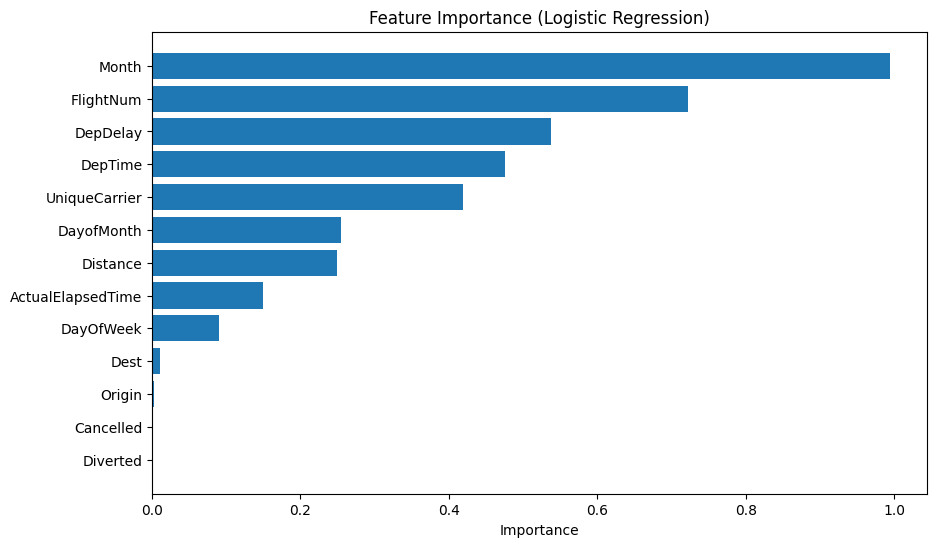

In [19]:
feature_importance_lr_91 = analyze_lr_features(LR91, processed_df91)

              Feature  Importance
3               Month    0.510204
5           DayOfWeek    0.489796
0       UniqueCarrier    0.000000
1              Origin    0.000000
2                Dest    0.000000
4          DayofMonth    0.000000
6             DepTime    0.000000
7           FlightNum    0.000000
8   ActualElapsedTime    0.000000
9            DepDelay    0.000000
10           Distance    0.000000
11          Cancelled    0.000000
12           Diverted    0.000000


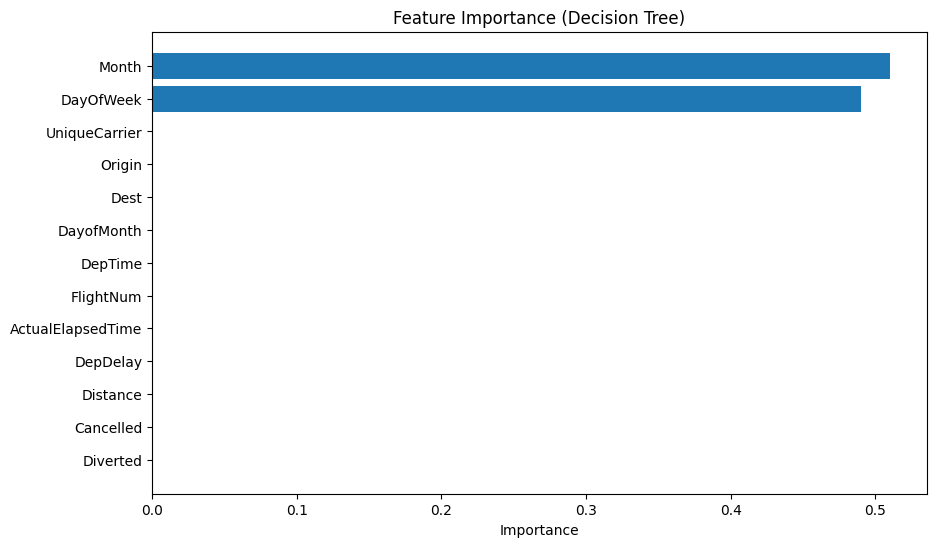

In [21]:
feature_importance_dt_91 = analyze_dt_features(DT91, processed_df91)